# Investigate the overturning stream function for the isomip+ simulations within the ice shelf cavity
Author: McKenzie Larson

In [1]:
## import modules
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors
import numpy as np

## `/ocean/isomip_plus/planar/2km/z-star/Ocean0`
Model time: 67 months

In [2]:
## load in the streamfunction data
ds = xr.open_dataset('/pscratch/sd/m/mlarson/isomip_plus_2km_z-star_Ocean0/ocean/isomip_plus/planar/2km/z-star/Ocean0/streamfunction/overturningStreamfunction.nc')

## load in the mesh and mask data for the 2-km grid
mesh = xr.open_dataset('/pscratch/sd/m/mlarson/dsMesh_2km.nc')
mask = xr.open_dataset('/pscratch/sd/m/mlarson/cavityMask_2km.nc')

In [4]:
ds

<xarray.Dataset> Size: 19MB
Dimensions:             (nx: 240, nz: 144, Time: 67)
Coordinates:
  * Time                (Time) object 536B 0001-01-16 12:00:00 ... 0006-07-16...
Dimensions without coordinates: nx, nz
Data variables:
    x                   (nx) float64 2kB ...
    z                   (nz) float64 1kB ...
    osf                 (Time, nz, nx) float64 19MB ...
    xtime_startMonthly  (Time) |S64 4kB ...
    xtime_endMonthly    (Time) |S64 4kB ...
Attributes:
    history:  Tue May 28 13:53:10 2024: /global/u2/m/mlarson/miniforge3/envs/...

In [3]:
## see if the middle of the hexagon cell is in the cavity
nCell_idx_inCavity = []
for i in range(len(mesh.nCells)):
     if (mask.maxLevelCell.isel(nCells=i).values == True): ## see if the middle of the hexagon cell is in the cavity
        nCell_idx_inCavity.append(i)
        
# get the mesh info for the cells in the cavity
nCell_inCavity = mesh.isel(nCells = nCell_idx_inCavity)

furthest_x = mesh.xCell.isel(nCells = nCell_idx_inCavity[np.argmax(nCell_inCavity.xCell.values)]).values
print('Largest x-value:', furthest_x)
furthest_x_idx = 159
print('Corresponding x-value in osf file:',ds.x.values[furthest_x_idx]) ## matches furthest_x of 639000.0

ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))

max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

Largest x-value: 639000.0
Corresponding x-value in osf file: 639000.0


For each month, plot the $y$-averaged OSF values in a cross-section along with the $y$-averaged OSF for all grid cells in a histogram.

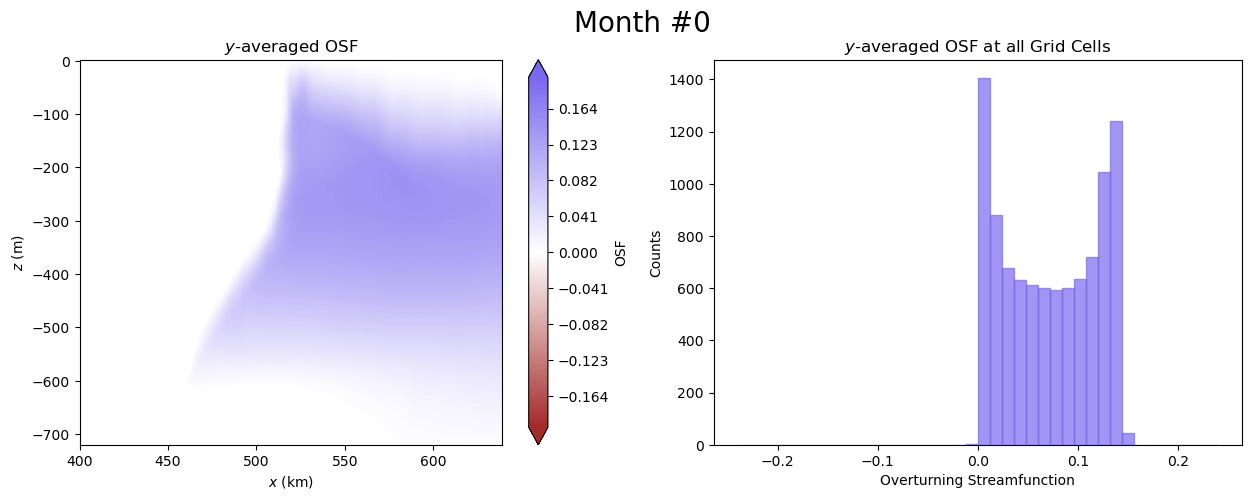

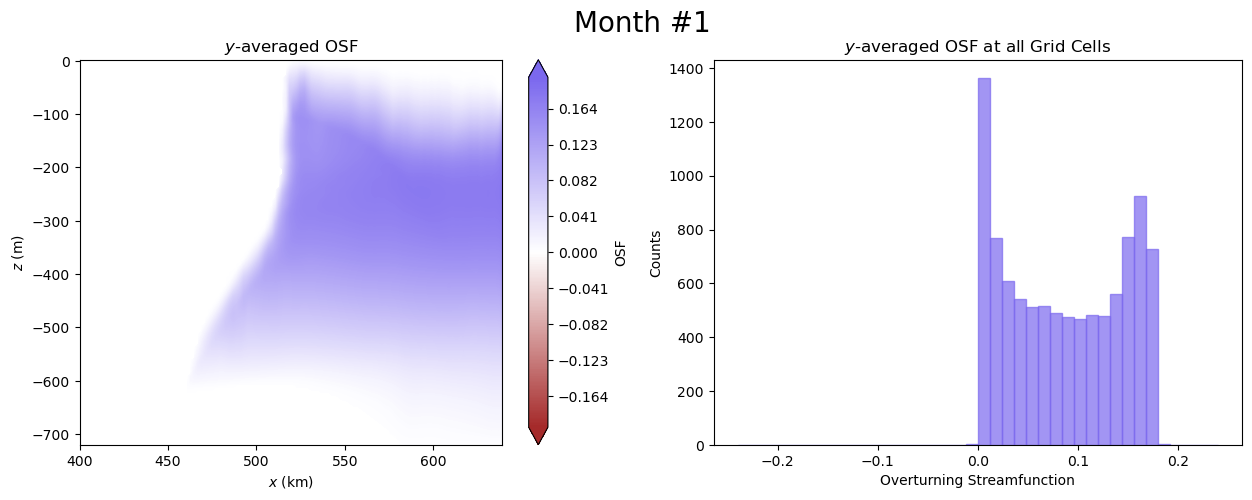

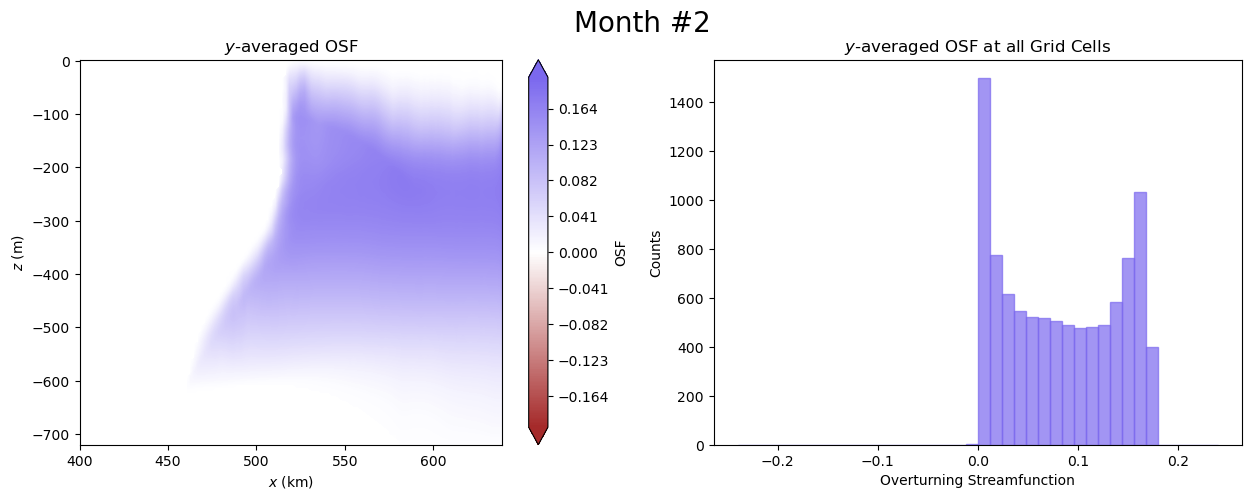

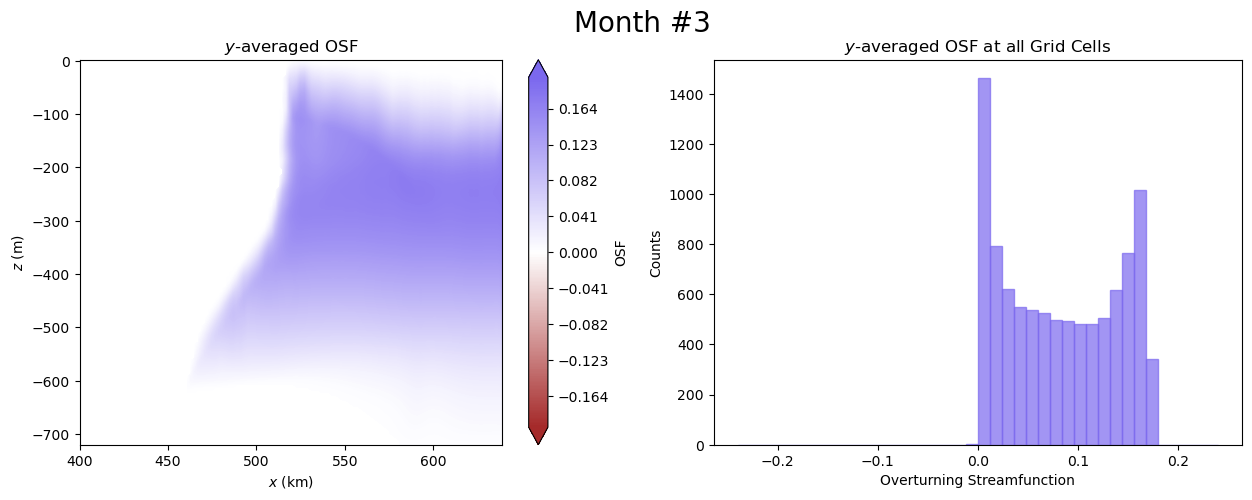

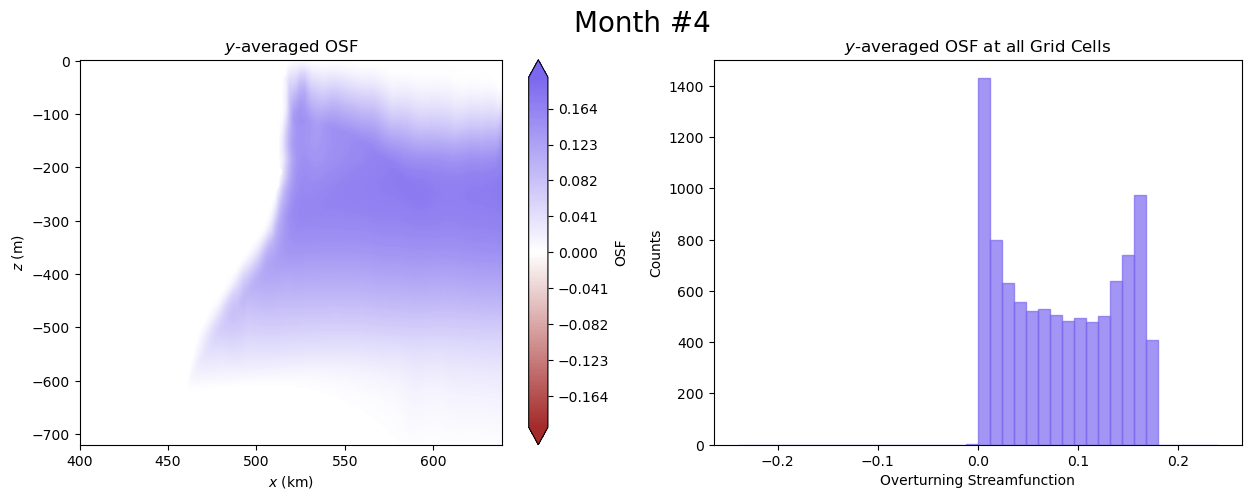

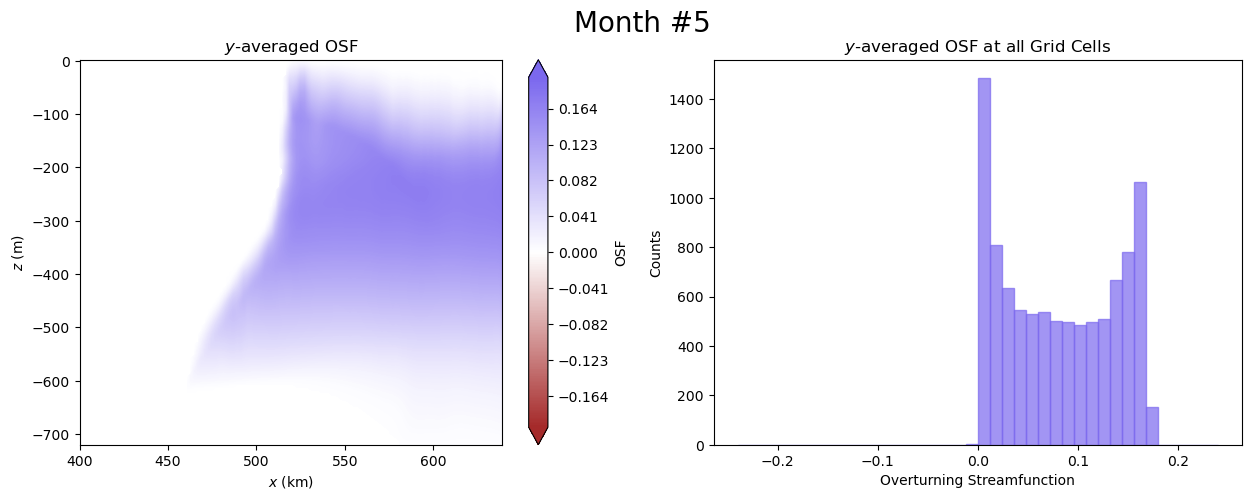

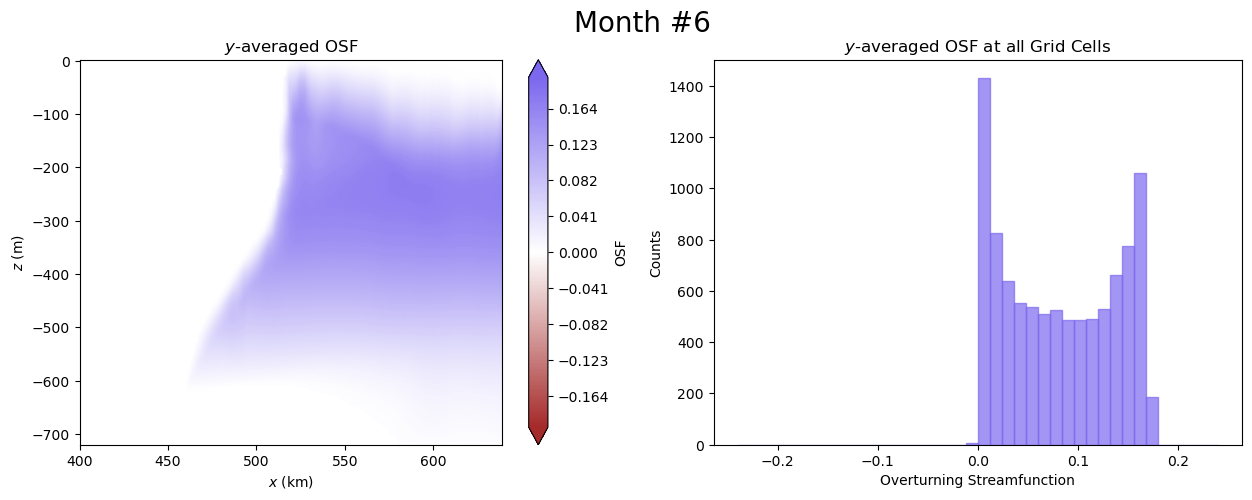

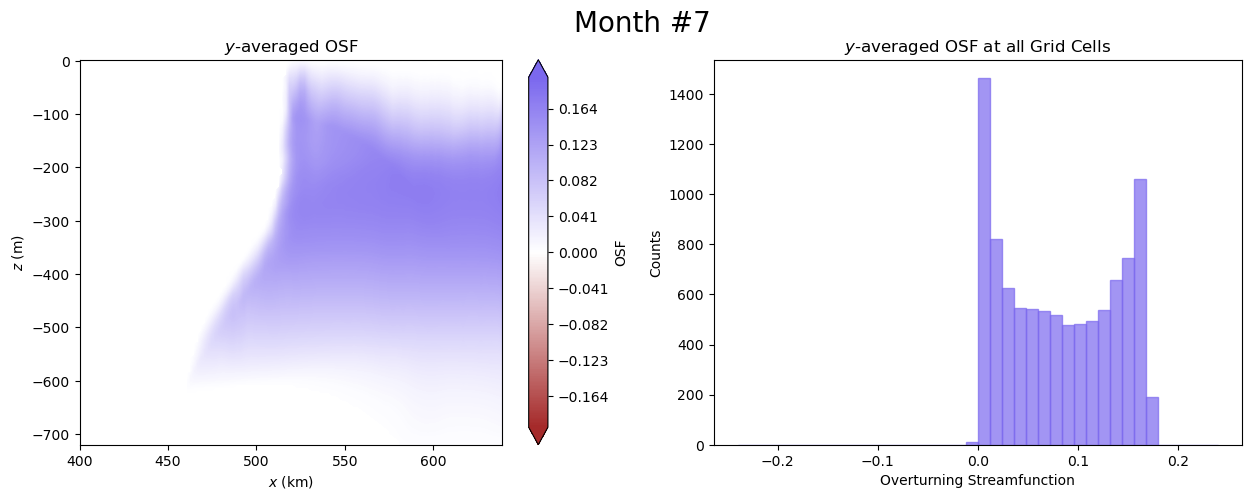

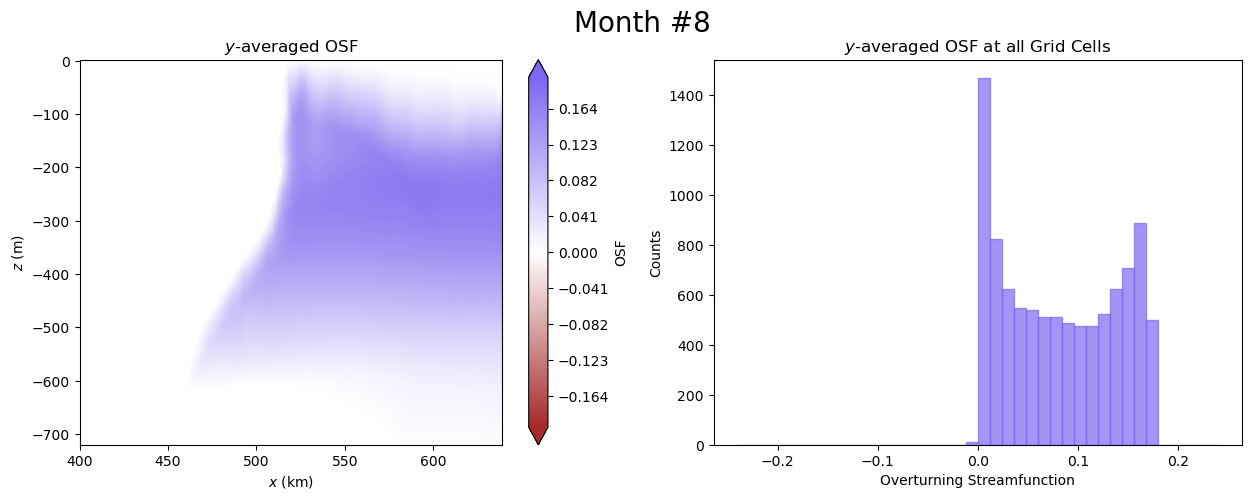

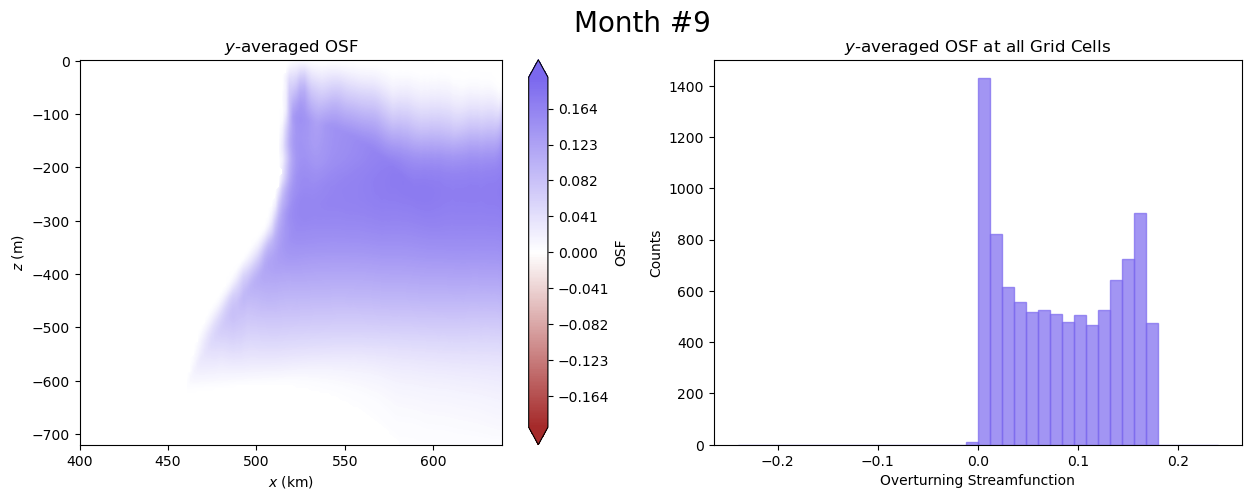

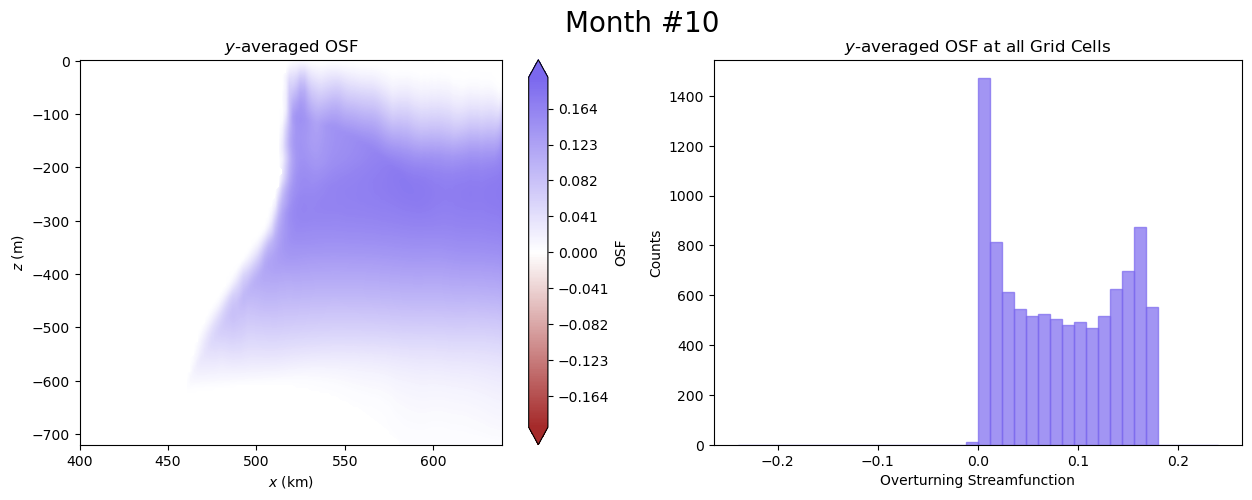

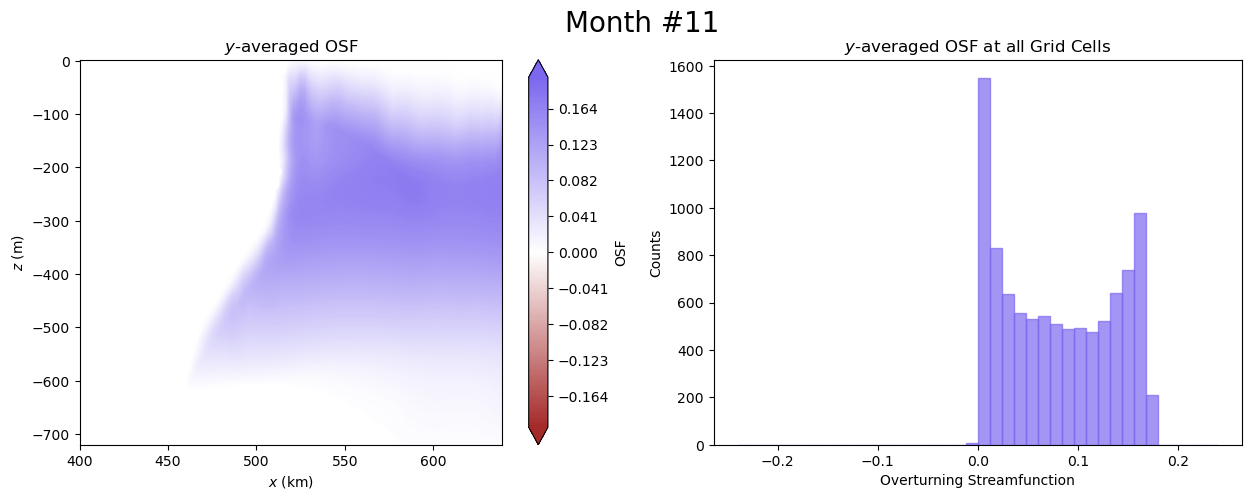

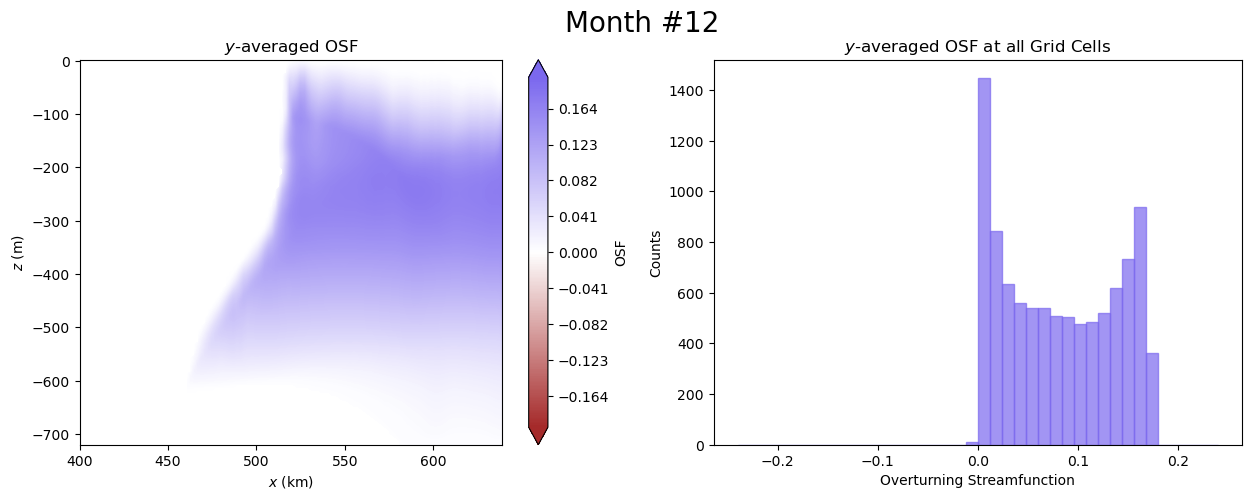

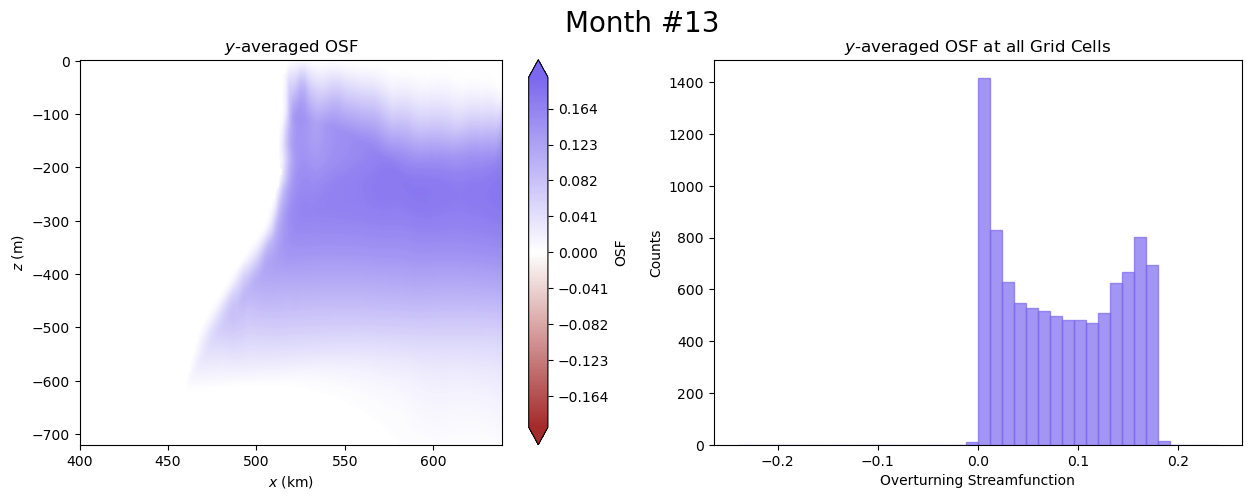

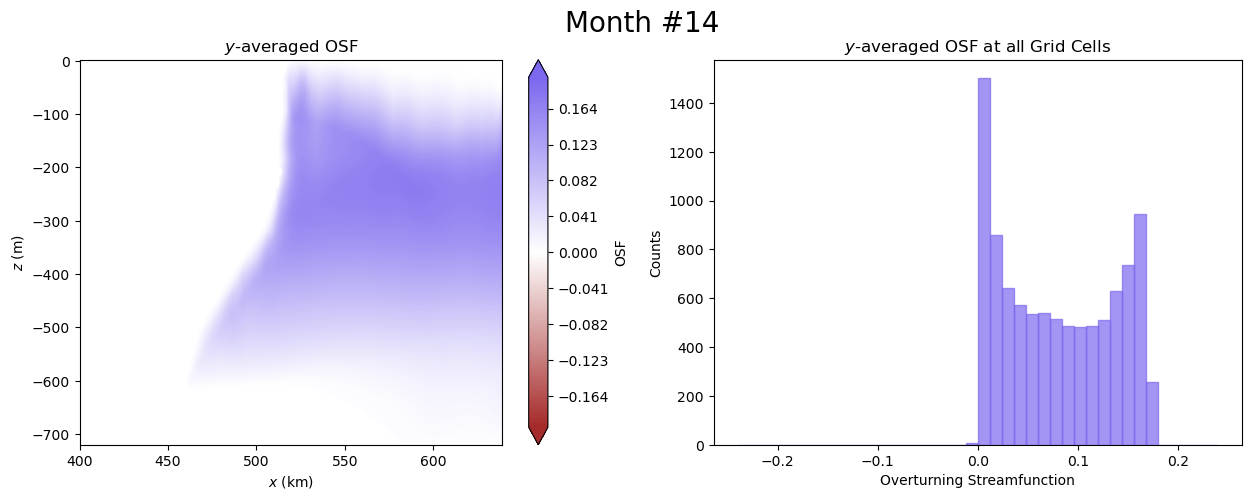

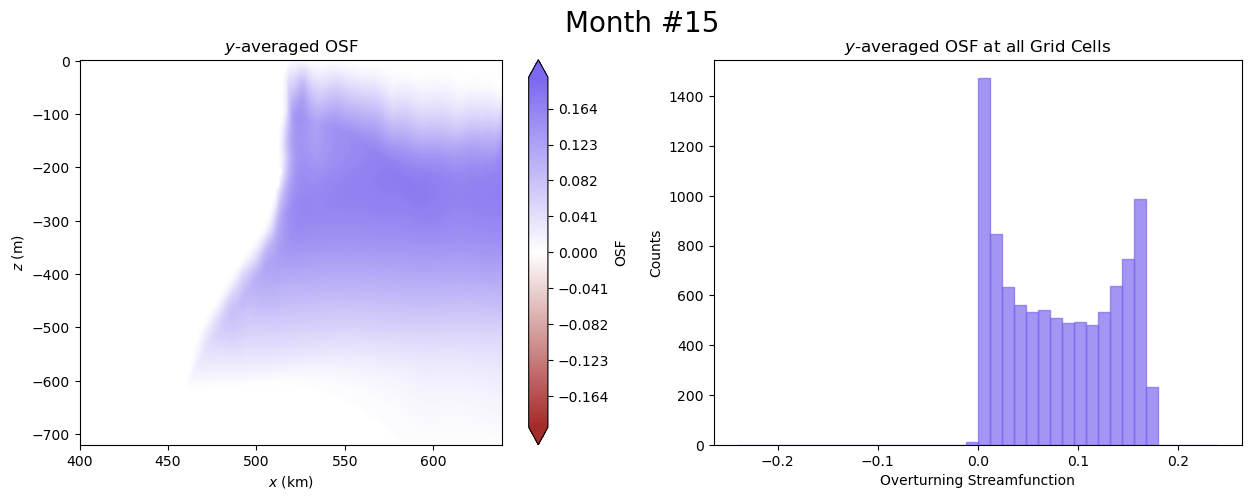

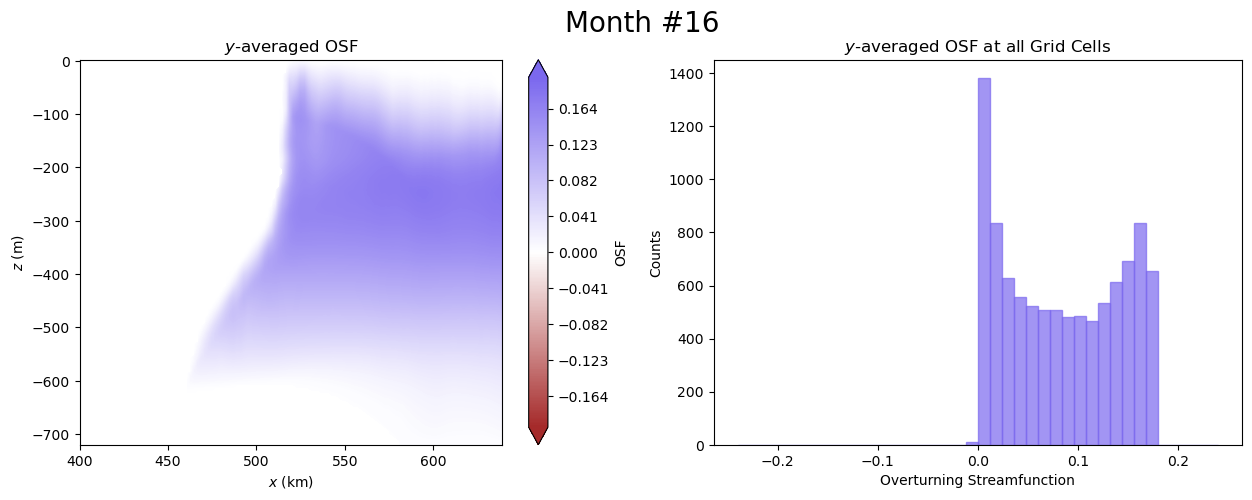

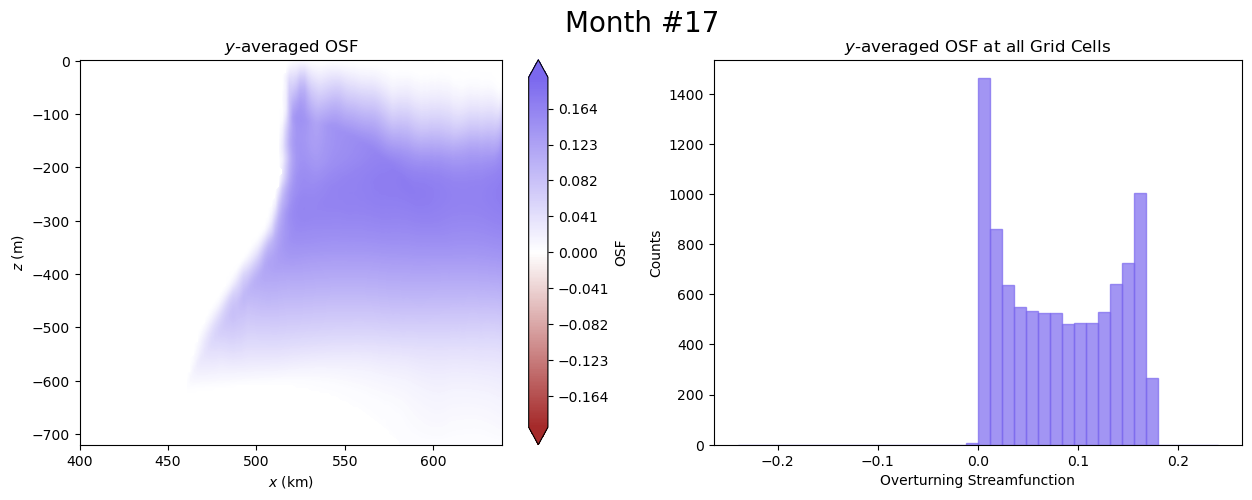

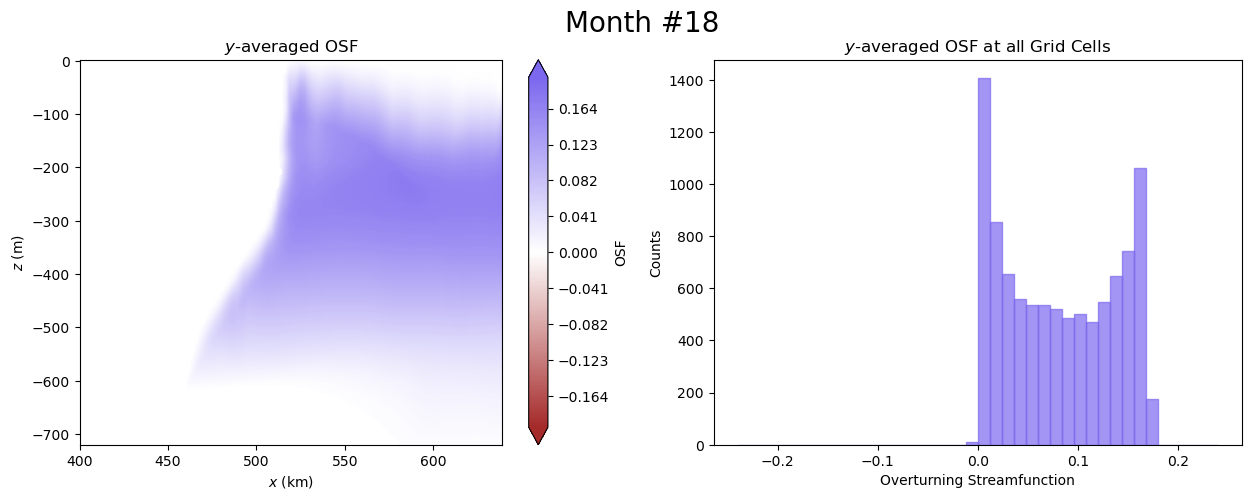

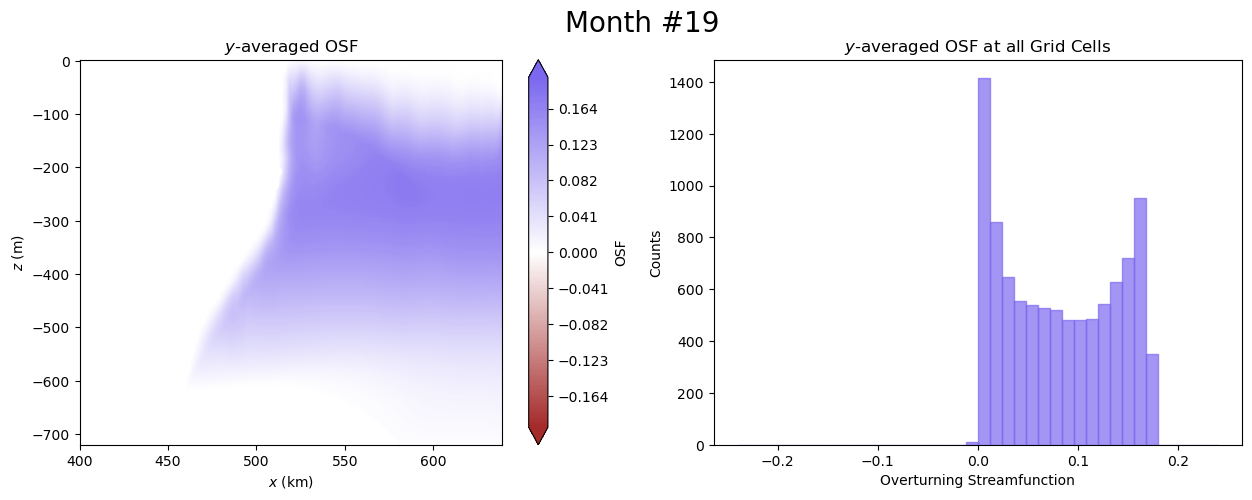

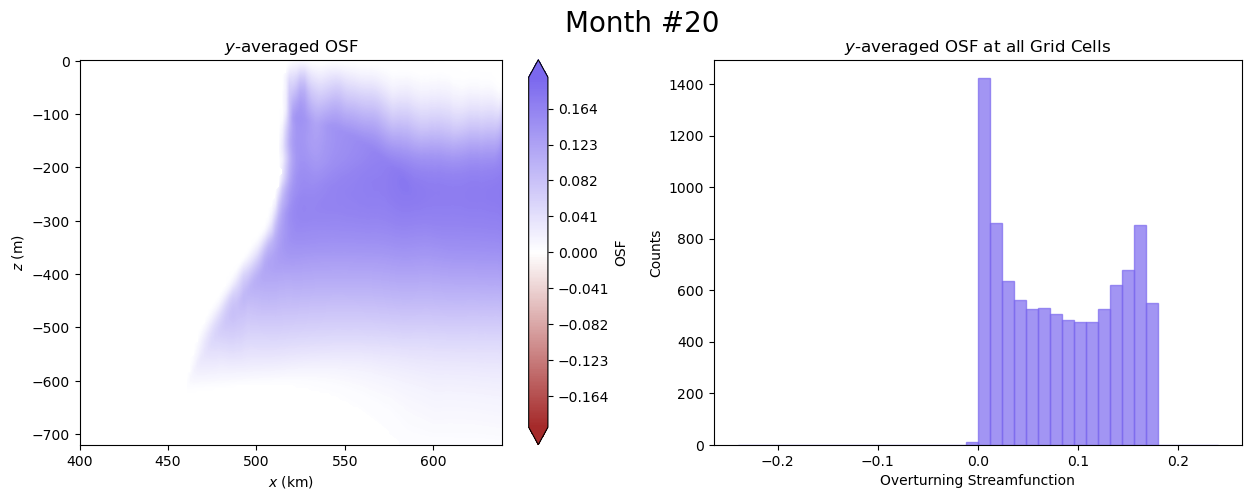

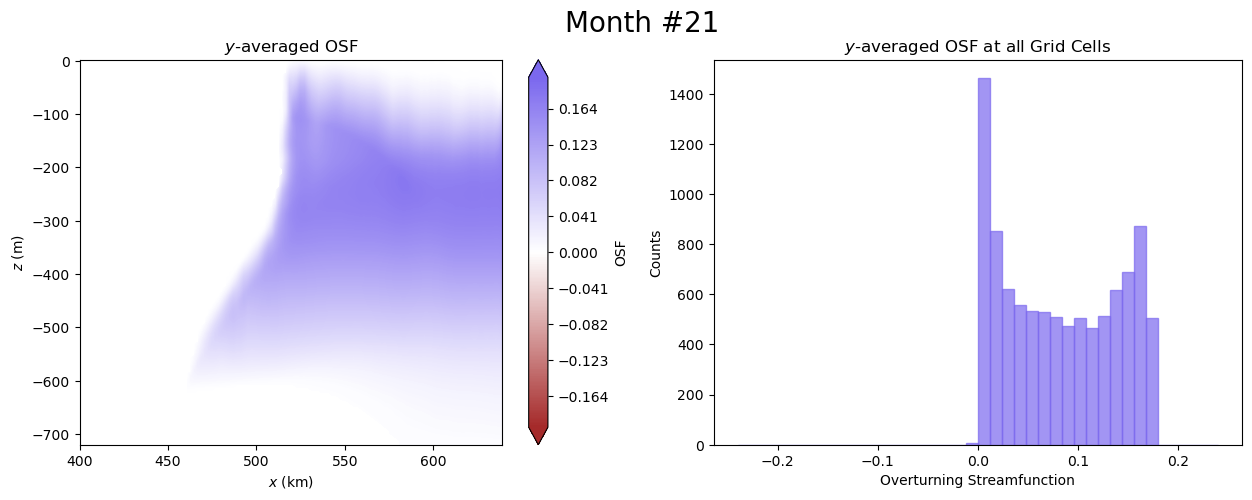

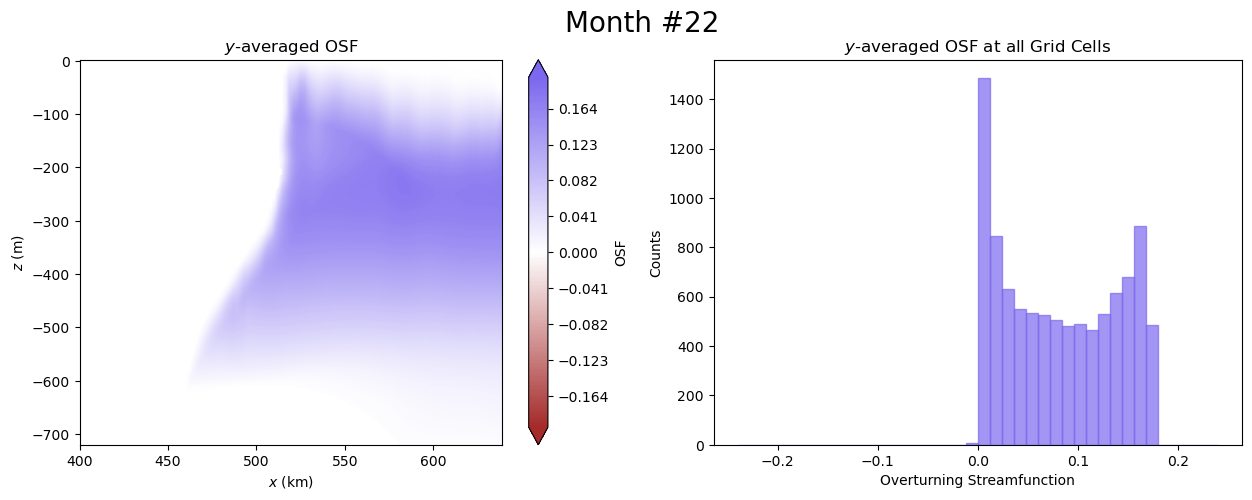

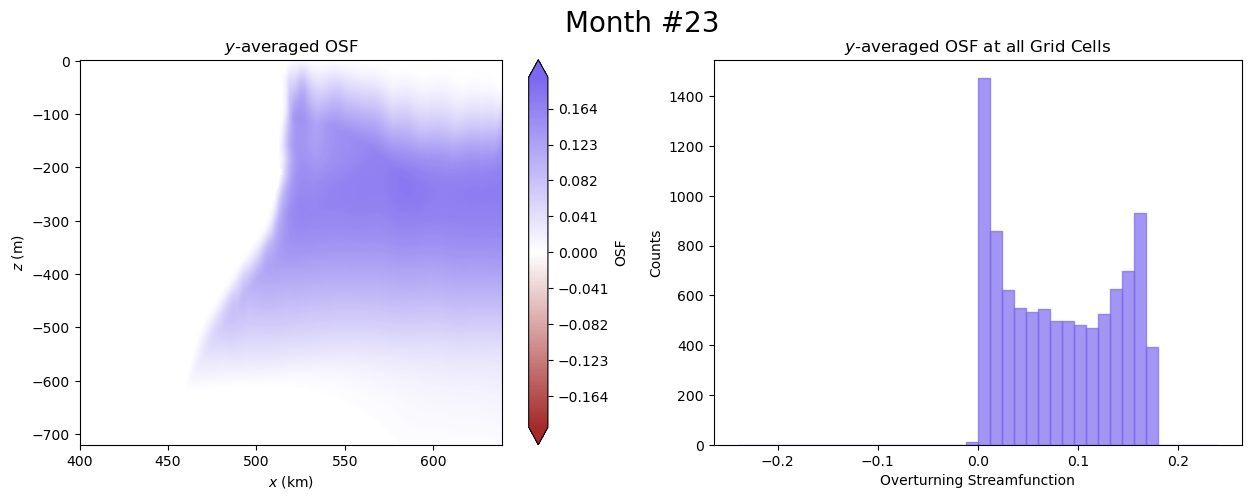

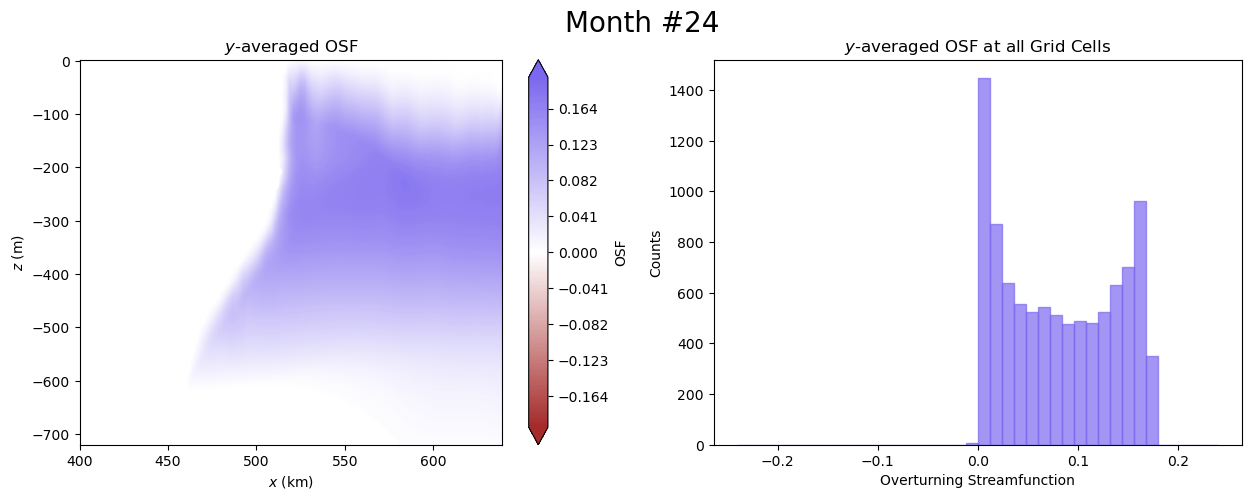

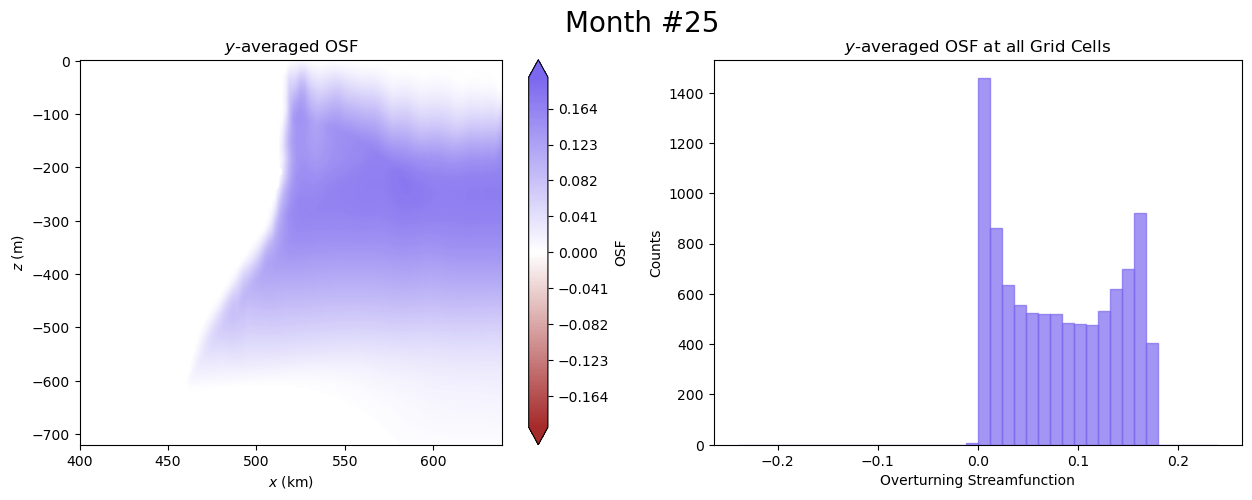

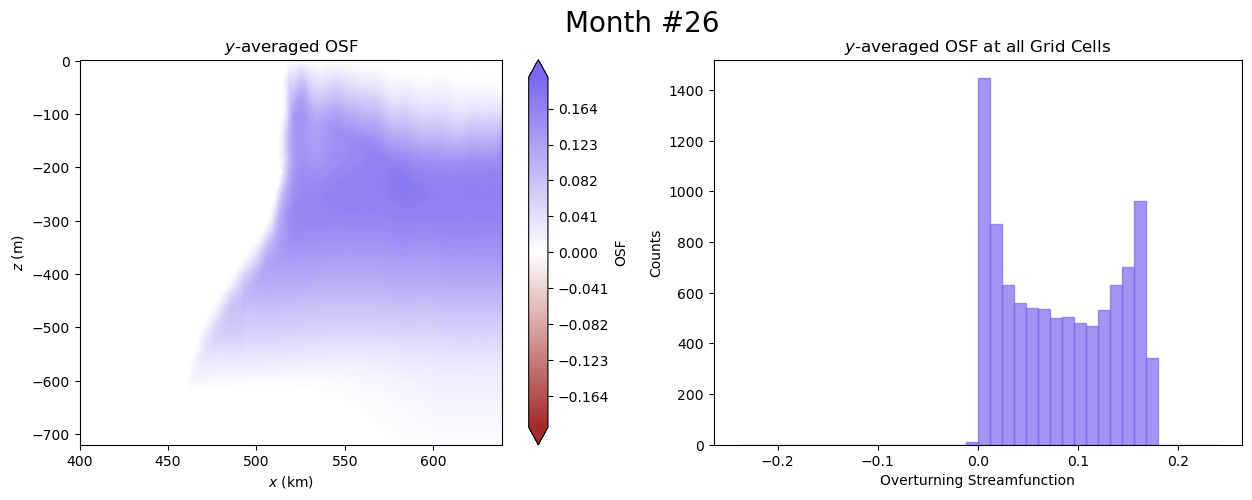

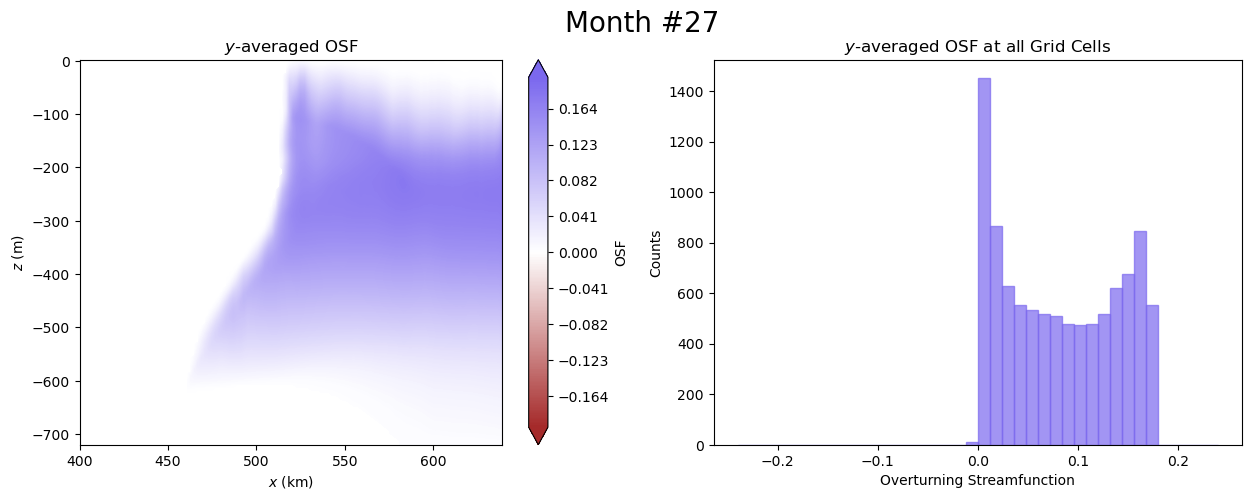

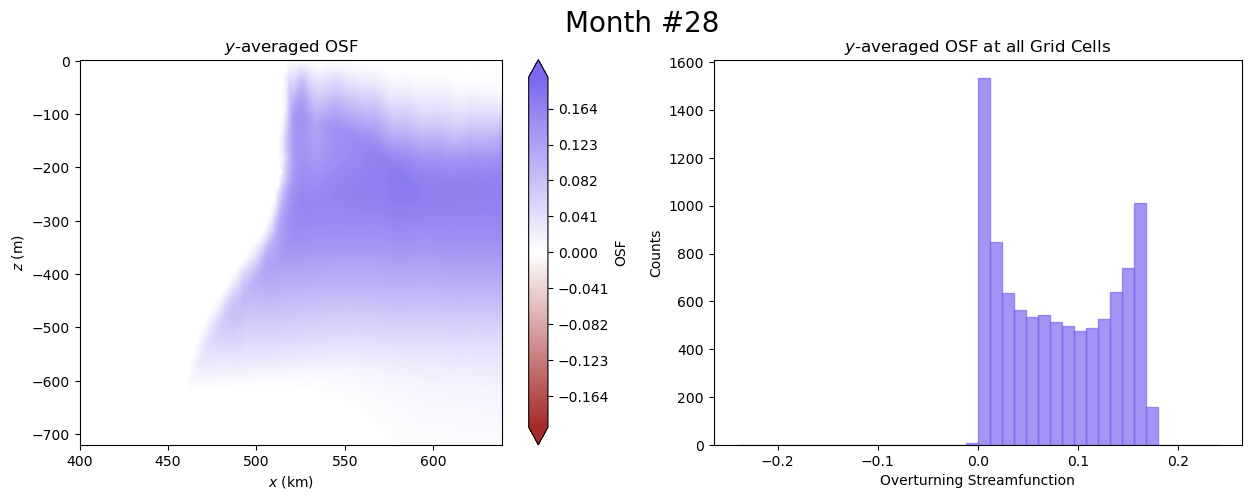

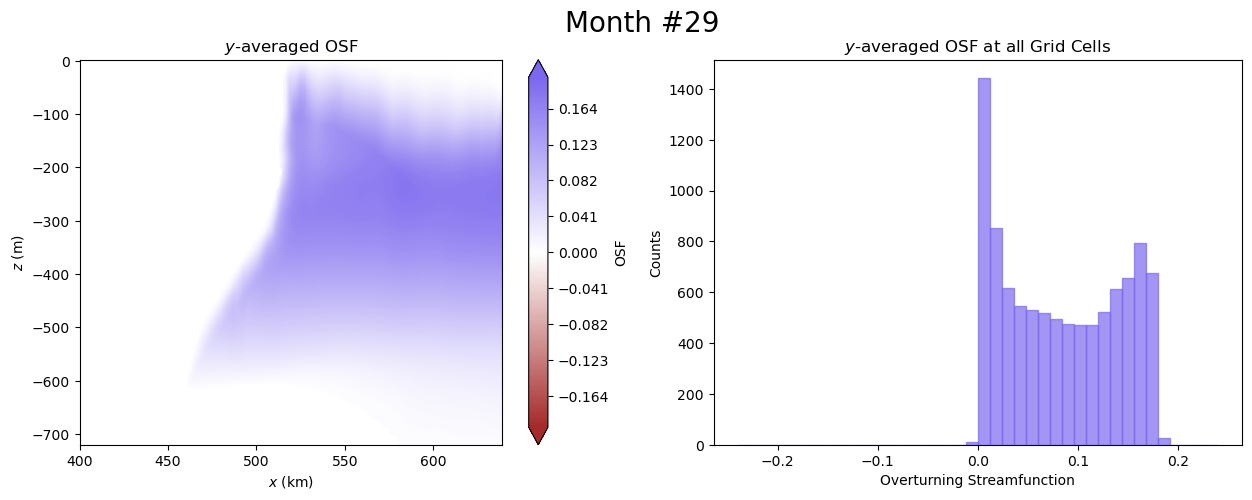

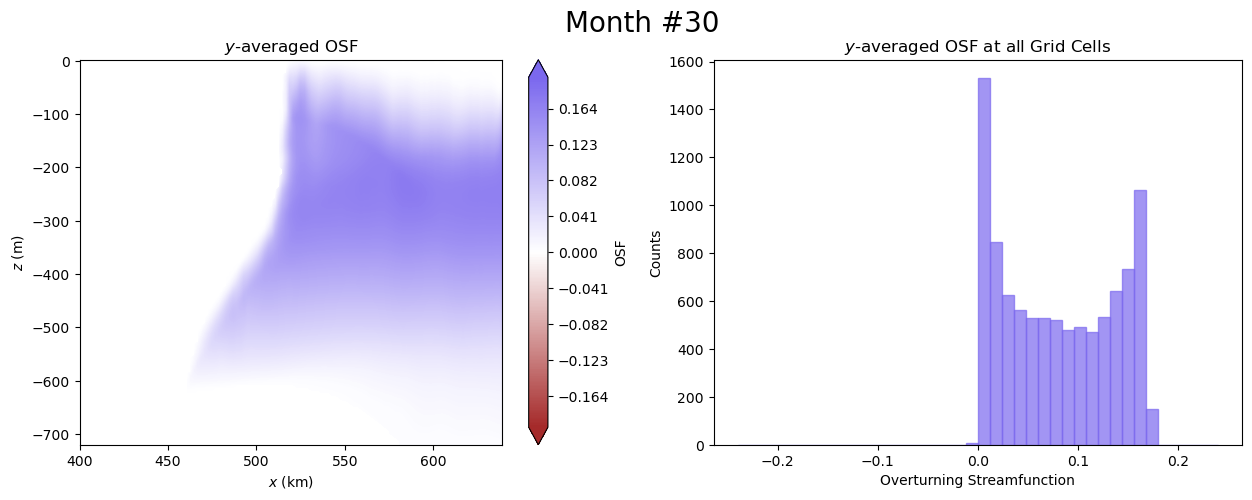

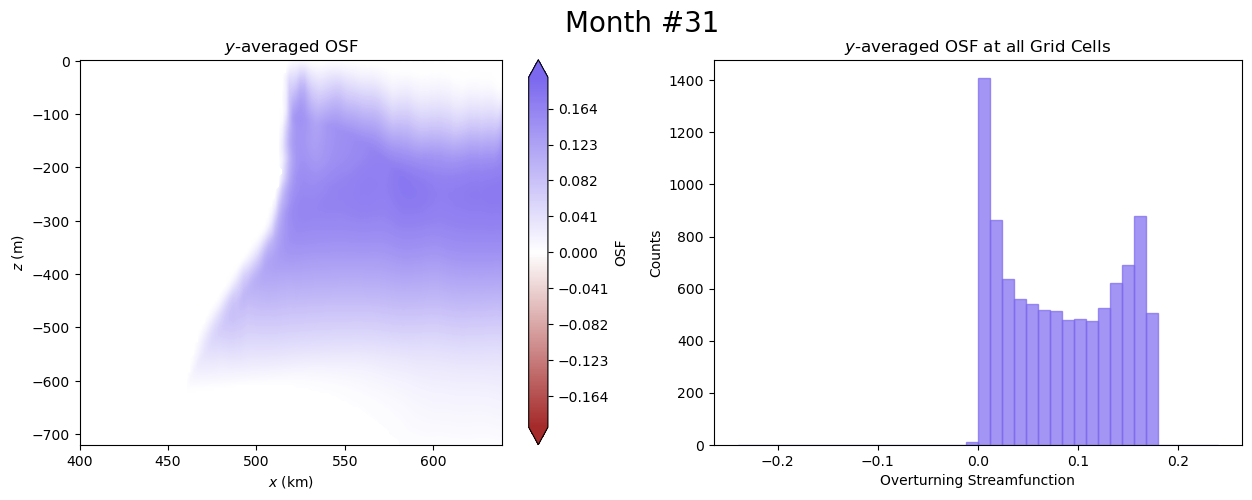

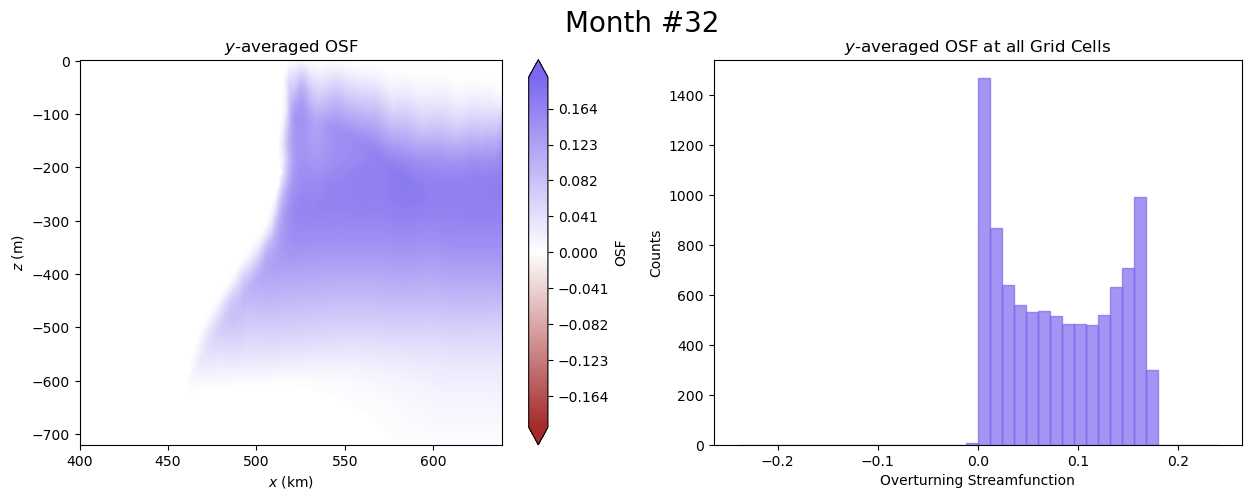

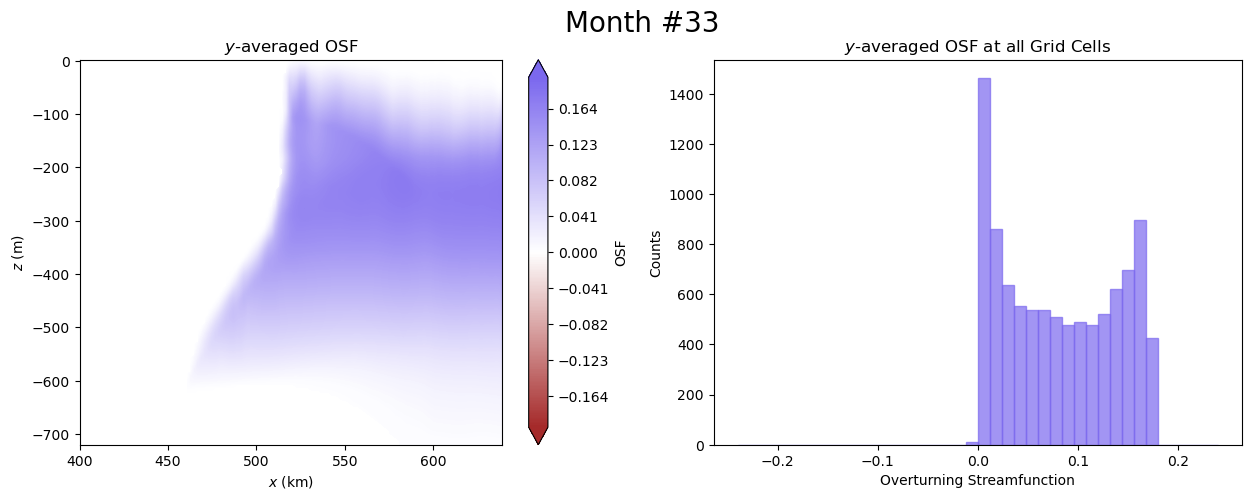

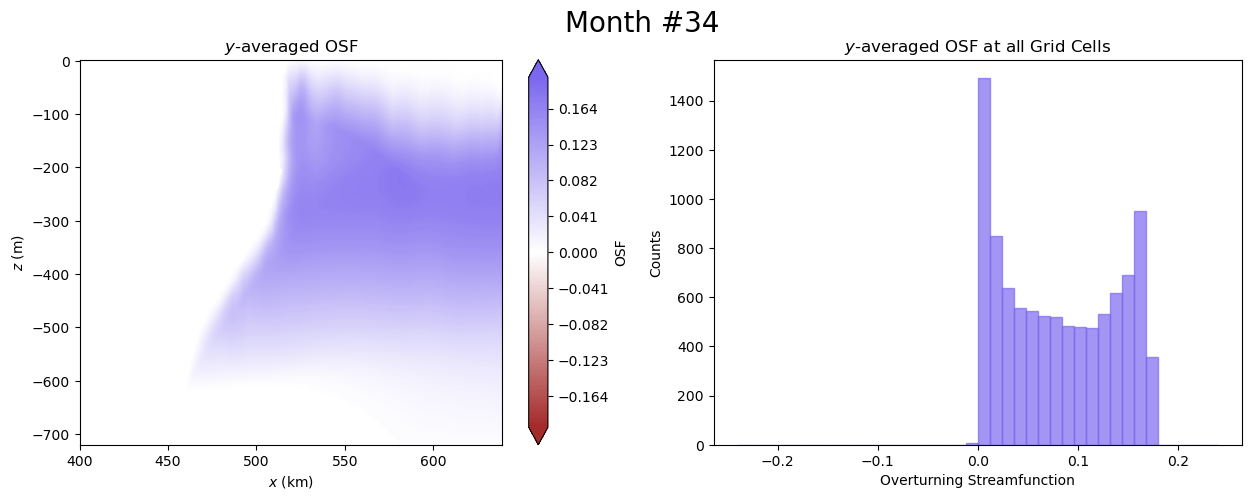

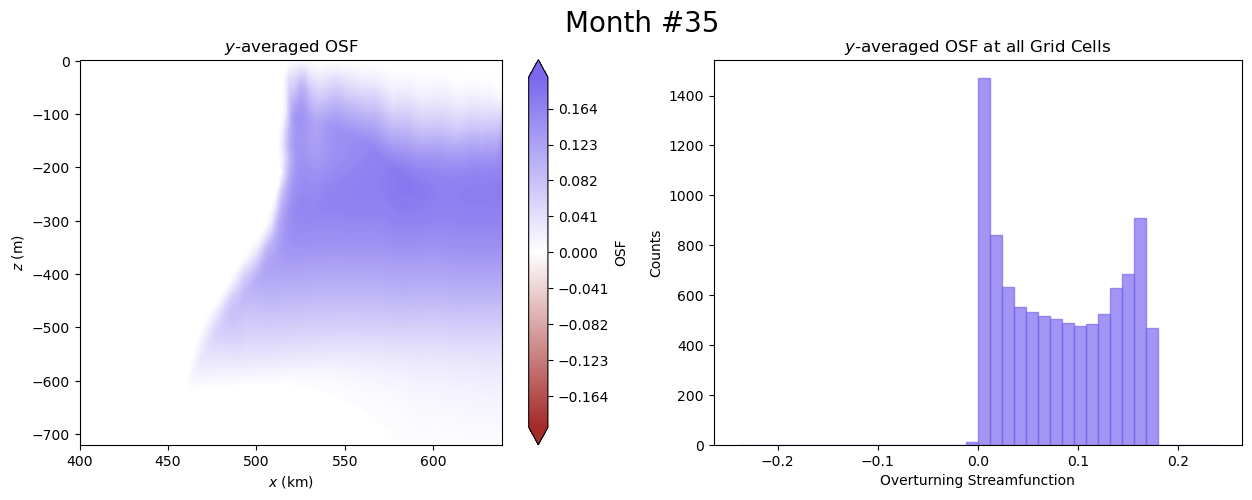

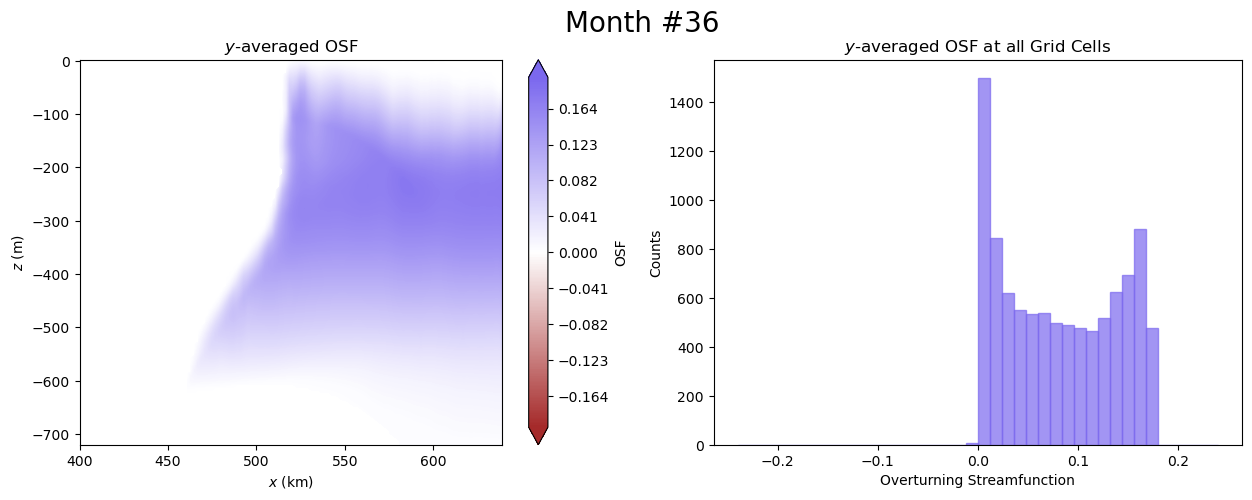

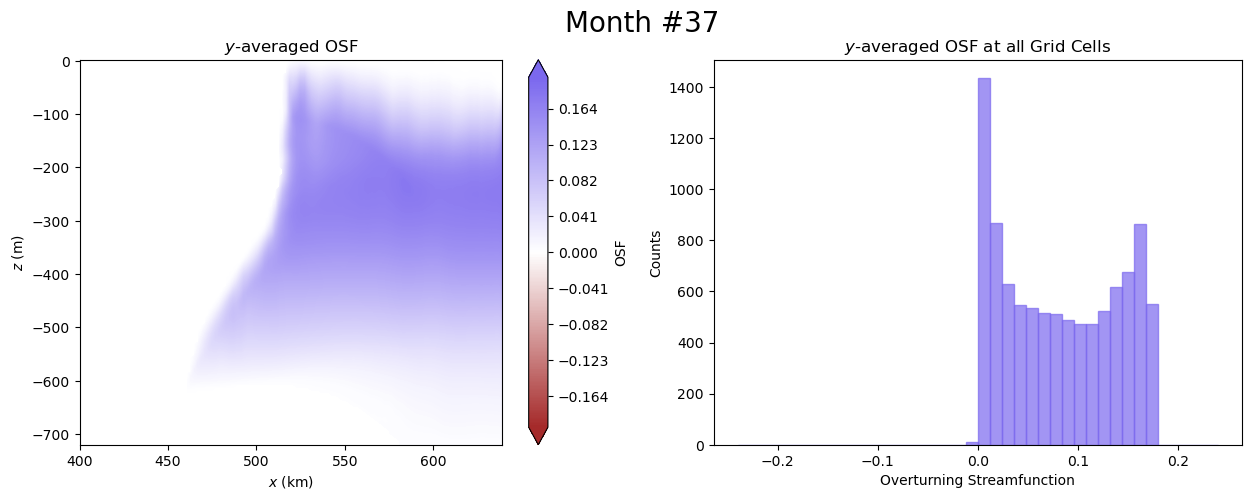

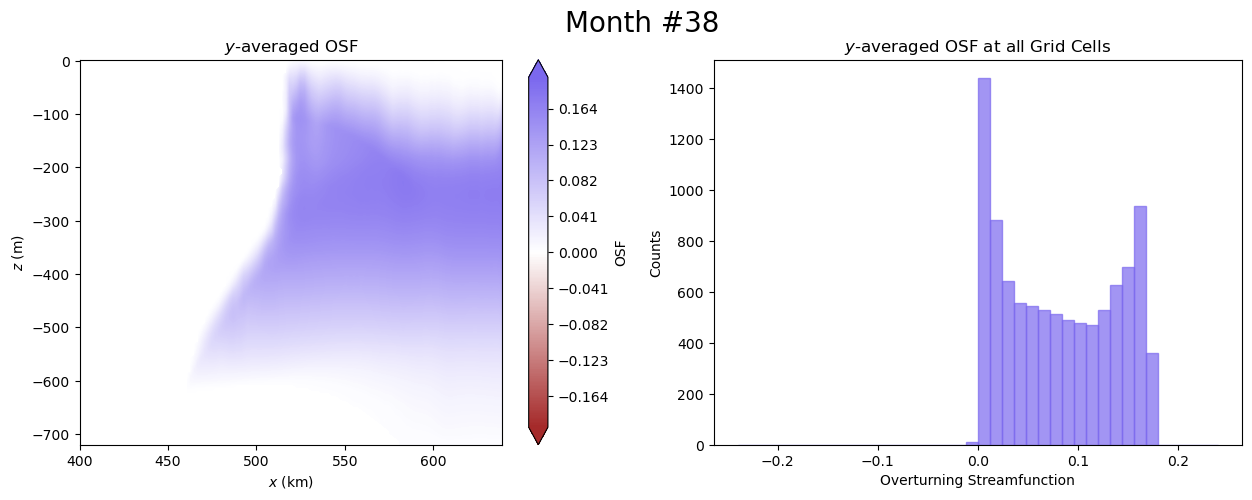

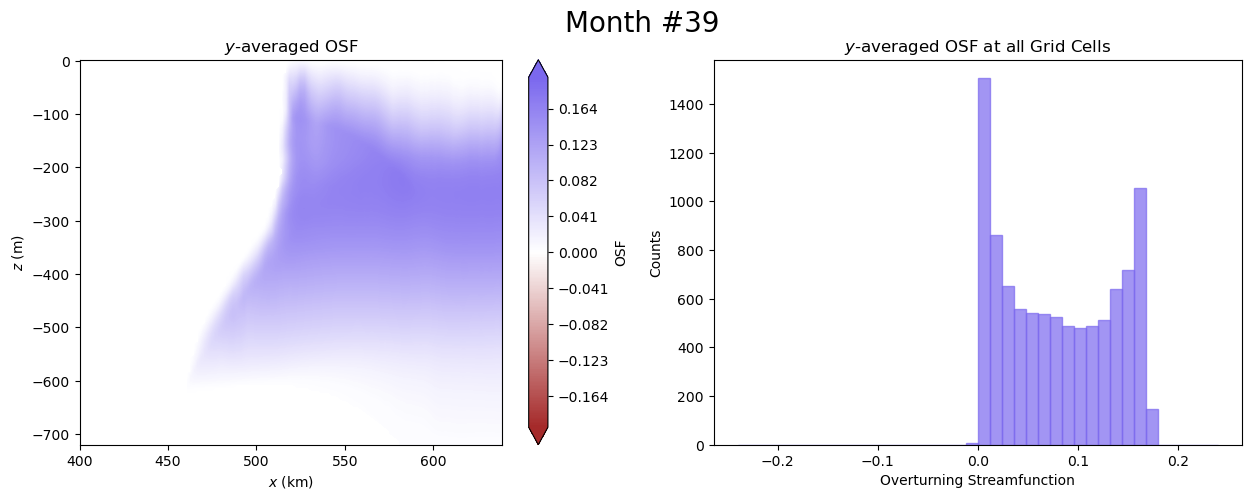

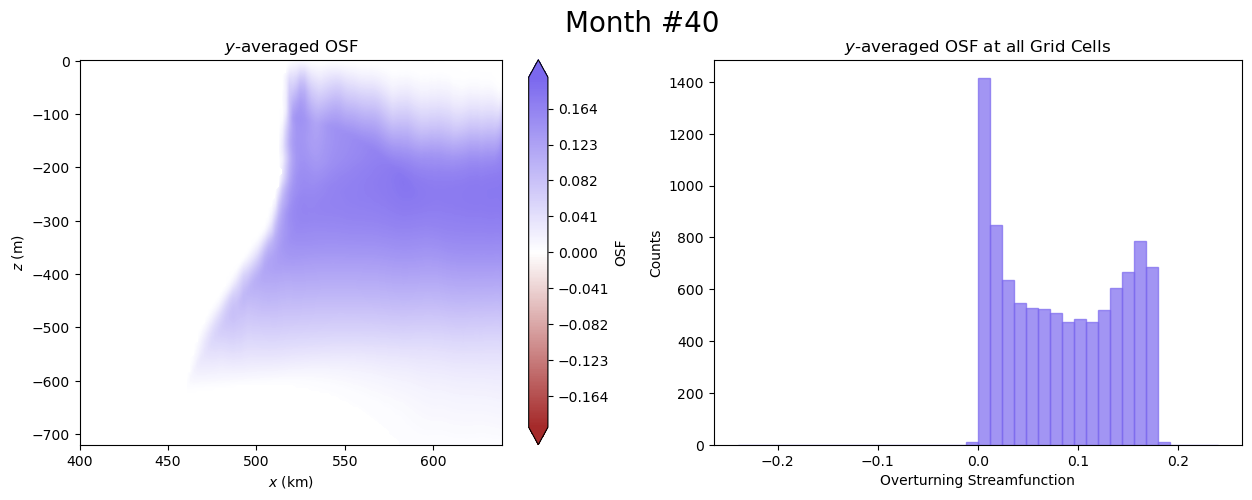

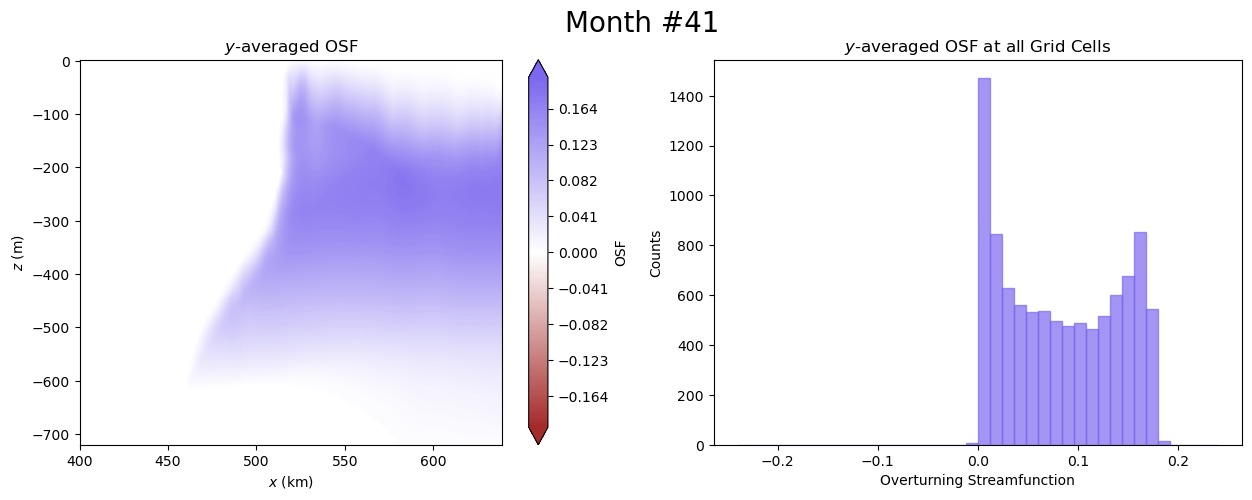

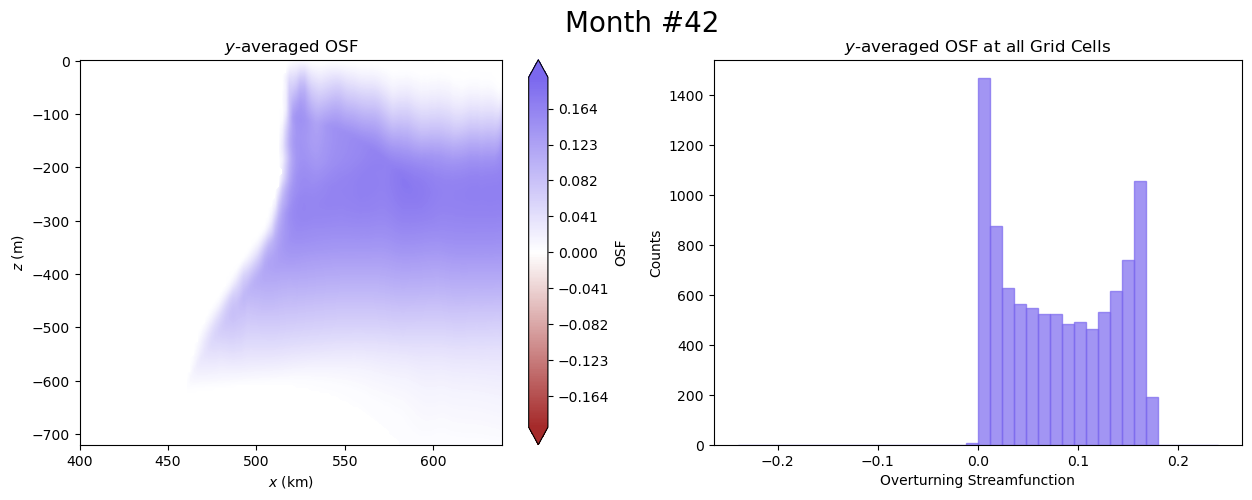

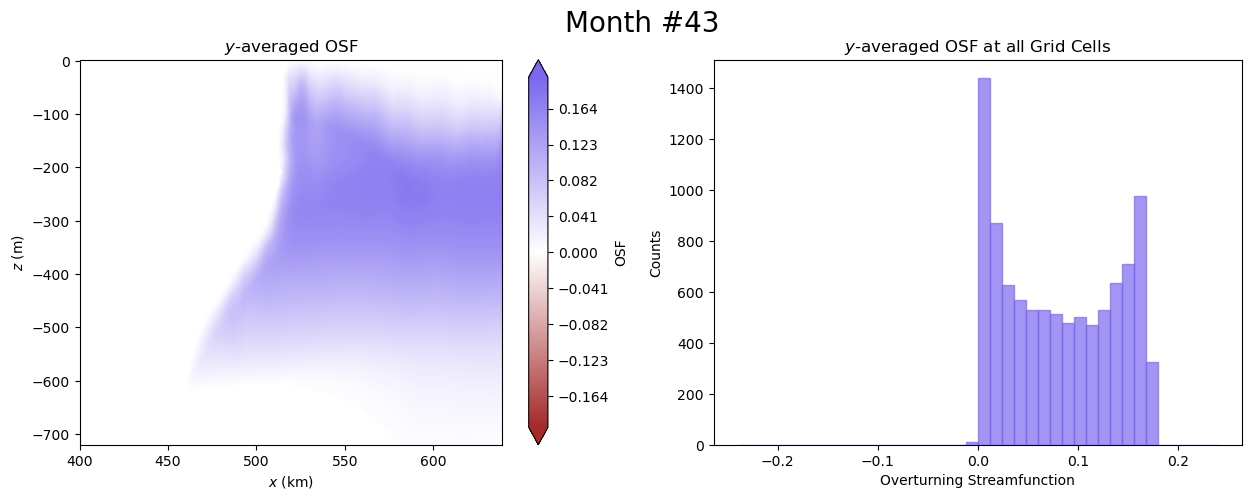

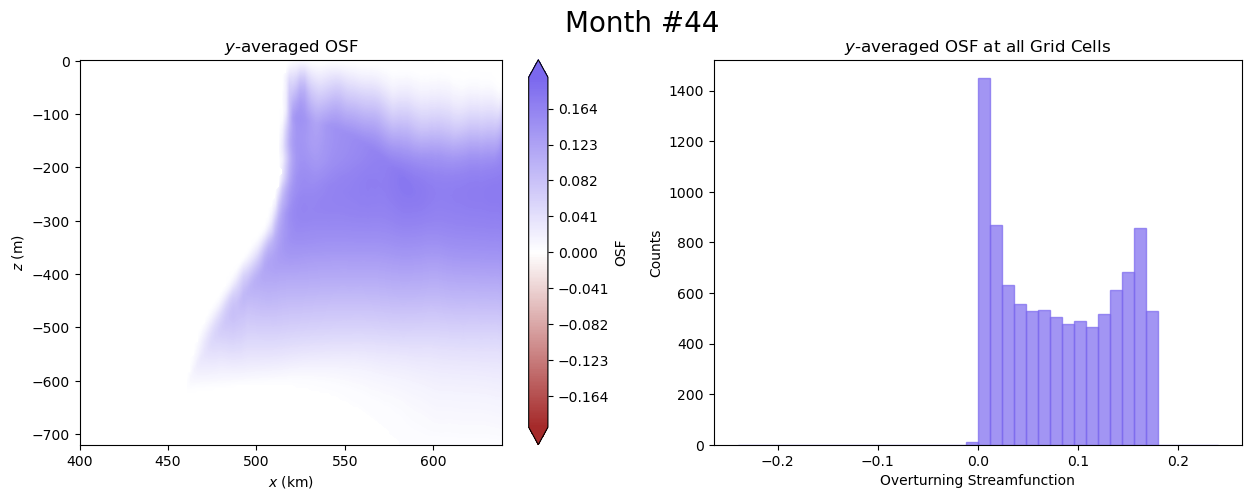

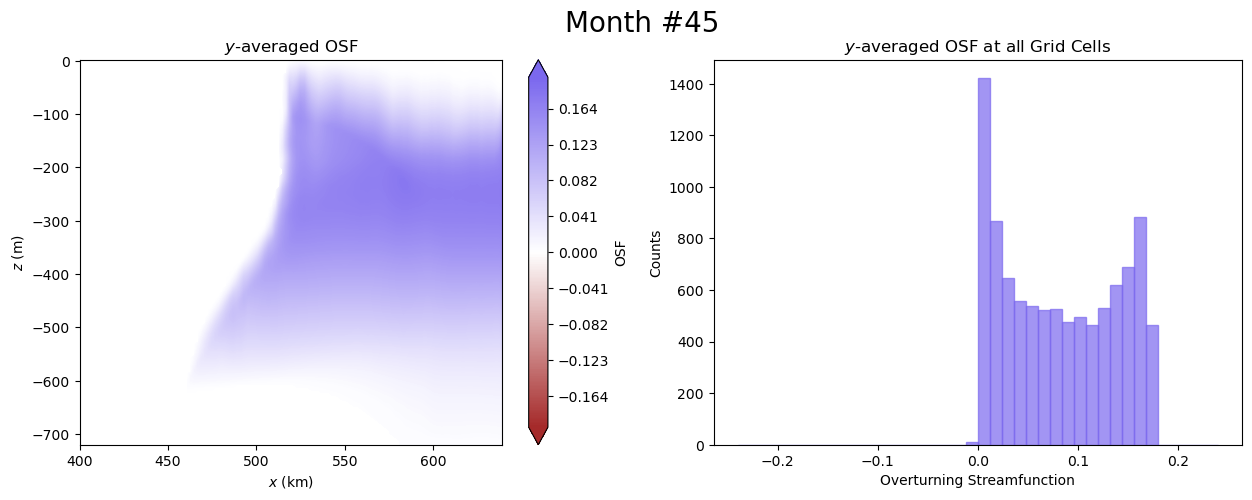

In [4]:
for midx in range(len(ds.Time)):
    fig, ax = plt.subplots(1,2, figsize = (15,5))

    ## create my own colormap
    cvals  = [-2., 0, 2]
    colors = ["brown","white","mediumslateblue"]

    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

    ## plot osf contours
    levs = np.arange(-0.2,0.201,0.001)
    im = ax[0].contourf(ds.x[0:furthest_x_idx+1]/1000,ds.z,ds.osf.isel(Time=midx, nx=slice(0,furthest_x_idx+1)), cmap=cmap, levels=levs, extend='both')
    # ax[0].contour(ds.x[0:furthest_x_idx+1]/1000,ds.z,ds.osf.isel(Time=0, nx=slice(0,furthest_x_idx+1)), cmap='Greys',levels=np.arange(-0.01,0.02,0.01))
    cb = fig.colorbar(im, orientation='vertical', label = 'OSF')
    ax[0].set_title('$y$-averaged OSF')
    ax[0].set_xlabel('$x$ (km)')
    ax[0].set_ylabel('$z$ (m)')
    ax[0].set_xlim(400, ds.x[furthest_x_idx]/1000)

    ## plot histogram
    ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1), Time = midx)
    data_1D = ds_inCavity.stack(stacked_nx_nz = ["nx", "nz"])
    data_1D = data_1D.osf.fillna(-999.).values ##make nans negative
    ax[1].hist(data_1D, bins=40,color='mediumslateblue',edgecolor='mediumslateblue',alpha=0.7,range=[-0.24,0.24])
    ax[1].set_title('$y$-averaged OSF at all Grid Cells')
    ax[1].set_xlabel('Overturning Streamfunction')
    ax[1].set_ylabel('Counts')

    fig.suptitle('Month #'+str(midx), size=20)
    plt.show()
    # break

Plot the max OSF and mean melt rate per month in a time series.

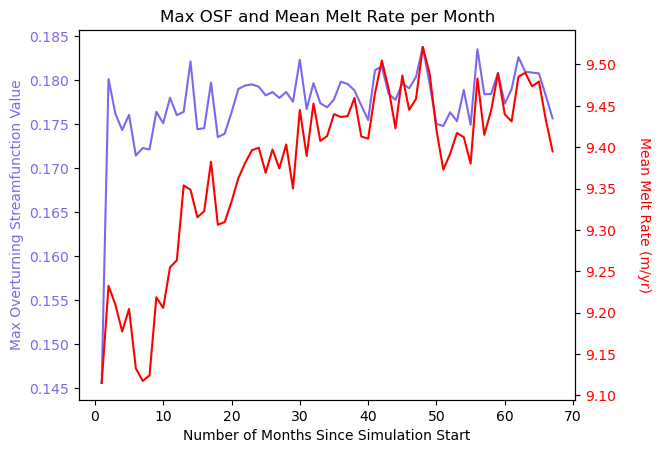

In [4]:
## calculate max osf per month
ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))
max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

## calculate the mean melt rate per month; adapted from compass source code
ds_output = xr.open_dataset('/pscratch/sd/m/mlarson/isomip_plus_2km_z-star_Ocean0/ocean/isomip_plus/planar/2km/z-star/Ocean0/simulation/land_ice_fluxes.nc')
ds_timeMonthly = xr.open_mfdataset('/pscratch/sd/m/mlarson/isomip_plus_2km_z-star_Ocean0/ocean/isomip_plus/planar/2km/z-star/Ocean0/simulation/timeSeriesStatsMonthly.*.nc')
rho_fw = 1000.
secPerYear = 365 * 24 * 60 * 60
areaCell = ds_output.areaCell
iceMask = ds_timeMonthly.timeMonthly_avg_landIceFraction
meltFlux = ds_timeMonthly.timeMonthly_avg_landIceFreshwaterFlux
totalMeltFlux = (meltFlux * areaCell * iceMask).sum(dim='nCells')
totalArea = (areaCell * iceMask).sum(dim='nCells')
meanMeltRate = totalMeltFlux / totalArea / rho_fw * secPerYear

## plot figure
fig, ax1 = plt.subplots()

##first plot the max OSF per month
ax1.plot(np.arange(1,len(ds_inCavity.Time)+1), max_osf, color='mediumslateblue')
ax1.set_ylabel('Max Overturning Streamfunction Value', color='mediumslateblue')
ax1.tick_params(axis='y', labelcolor='mediumslateblue')

ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(ds_output.Time)+1),meanMeltRate,color='red')
ax2.set_ylabel('Mean Melt Rate (m/yr)', color='red', rotation=-90, labelpad=25)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Max OSF and Mean Melt Rate per Month')
ax1.set_xlabel('Number of Months Since Simulation Start')
plt.show()

## `/ocean/isomip_plus/planar/2km/sigma/Ocean0`
Recreate the above plot using the sigma coordinate simulation:

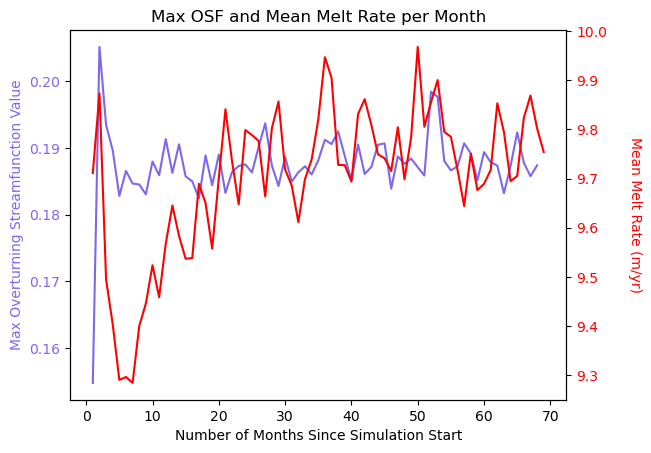

In [5]:
ds = xr.open_dataset('/pscratch/sd/m/mlarson/isomip_plus_2km_sigma_Ocean0/ocean/isomip_plus/planar/2km/sigma/Ocean0/streamfunction/overturningStreamfunction.nc')
## calculate max osf per month
ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))
max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

## calculate the mean melt rate per month; adapted from compass source code
ds_output = xr.open_dataset('/pscratch/sd/m/mlarson/isomip_plus_2km_sigma_Ocean0/ocean/isomip_plus/planar/2km/sigma/Ocean0/simulation/land_ice_fluxes.nc')
ds_timeMonthly = xr.open_mfdataset('/pscratch/sd/m/mlarson/isomip_plus_2km_sigma_Ocean0/ocean/isomip_plus/planar/2km/sigma/Ocean0/simulation/timeSeriesStatsMonthly.*.nc')
rho_fw = 1000.
secPerYear = 365 * 24 * 60 * 60
areaCell = ds_output.areaCell
iceMask = ds_timeMonthly.timeMonthly_avg_landIceFraction
meltFlux = ds_timeMonthly.timeMonthly_avg_landIceFreshwaterFlux
totalMeltFlux = (meltFlux * areaCell * iceMask).sum(dim='nCells')
totalArea = (areaCell * iceMask).sum(dim='nCells')
meanMeltRate = totalMeltFlux / totalArea / rho_fw * secPerYear

## plot figure
fig, ax1 = plt.subplots()

##first plot the max OSF per month
ax1.plot(np.arange(1,len(ds_inCavity.Time)+1), max_osf, color='mediumslateblue')
ax1.set_ylabel('Max Overturning Streamfunction Value', color='mediumslateblue')
ax1.tick_params(axis='y', labelcolor='mediumslateblue')

ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(ds_output.Time)+1),meanMeltRate,color='red')
ax2.set_ylabel('Mean Melt Rate (m/yr)', color='red', rotation=-90, labelpad=25)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Max OSF and Mean Melt Rate per Month')
ax1.set_xlabel('Number of Months Since Simulation Start')
plt.show()

In [3]:
ds = xr.open_dataset('/pscratch/sd/m/mlarson/pr_100_allSteps/ocean/isomip_plus/planar/5km/z-star/Ocean0/streamfunction/overturningStreamfunction.nc')
## calculate max osf per month
ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))
max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

## calculate the mean melt rate per month; adapted from compass source code
ds_output = xr.open_dataset('/pscratch/sd/m/mlarson/pr_100_allSteps/ocean/isomip_plus/planar/5km/z-star/Ocean0/simulation/land_ice_fluxes.nc')
ds_timeMonthly = xr.open_mfdataset('/pscratch/sd/m/mlarson/pr_100_allSteps/ocean/isomip_plus/planar/5km/z-star/Ocean0/simulation/timeSeriesStatsMonthly.*.nc')
rho_fw = 1000.
secPerYear = 365 * 24 * 60 * 60
areaCell = ds_output.areaCell
iceMask = ds_timeMonthly.timeMonthly_avg_landIceFraction
meltFlux = ds_timeMonthly.timeMonthly_avg_landIceFreshwaterFlux
totalMeltFlux = (meltFlux * areaCell * iceMask).sum(dim='nCells')
totalArea = (areaCell * iceMask).sum(dim='nCells')
meanMeltRate = totalMeltFlux / totalArea / rho_fw * secPerYear


## plot figure
fig, ax1 = plt.subplots()

##first plot the max OSF per month
ax1.plot(np.arange(1,len(ds_inCavity.Time)+1), max_osf, color='mediumslateblue')
ax1.set_ylabel('Max Overturning Streamfunction Value', color='mediumslateblue')
ax1.tick_params(axis='y', labelcolor='mediumslateblue')

ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(ds_output.Time)+1),meanMeltRate,color='red')
ax2.set_ylabel('Mean Melt Rate (m/yr)', color='red', rotation=-90, labelpad=25)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Max OSF and Mean Melt Rate per Month')
ax1.set_xlabel('Number of Months Since Simulation Start')
plt.show()

NameError: name 'furthest_x_idx' is not defined

## RK4 simulations

In [24]:
## load in the streamfunction data
ds = xr.open_dataset('/pscratch/sd/m/mlarson/RK4/z-lev_5km/ocean/isomip_plus/planar/5km/z-level/Ocean0/streamfunction/overturningStreamfunction.nc')
ds_output = xr.open_dataset('/pscratch/sd/m/mlarson/RK4/z-lev_5km/ocean/isomip_plus/planar/5km/z-level/Ocean0/simulation/output.nc')
## load in the mesh and mask data for the 5-km grid
mask = xr.open_dataset('/pscratch/sd/m/mlarson/RK4/z-lev_5km/ocean/isomip_plus/planar/5km/z-level/Ocean0/viz/cavityMask.nc')


FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/m/mlarson/RK4/z-star_2km/ocean/isomip_plus/planar/2km/z-star/Ocean0/streamfunction/overturningStreamfunction.nc'

In [22]:
## see if the middle of the hexagon cell is in the cavity
nCell_idx_inCavity = []
for i in range(len(ds_output.nCells)):
     if (mask.maxLevelCell.isel(nCells=i).values == True): ## see if the middle of the hexagon cell is in the cavity
        nCell_idx_inCavity.append(i)
        
# get the mesh info for the cells in the cavity
nCell_inCavity = ds_output.isel(nCells = nCell_idx_inCavity)

furthest_x = ds_output.xCell.isel(nCells = nCell_idx_inCavity[np.argmax(nCell_inCavity.xCell.values)]).values
print('Largest x-value:', furthest_x)
furthest_x_idx = 159
print('Corresponding x-value in osf file:',ds.x.values[furthest_x_idx]) ## matches furthest_x of 639000.0

ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))

max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

Largest x-value: 637500.0
Corresponding x-value in osf file: 639000.0


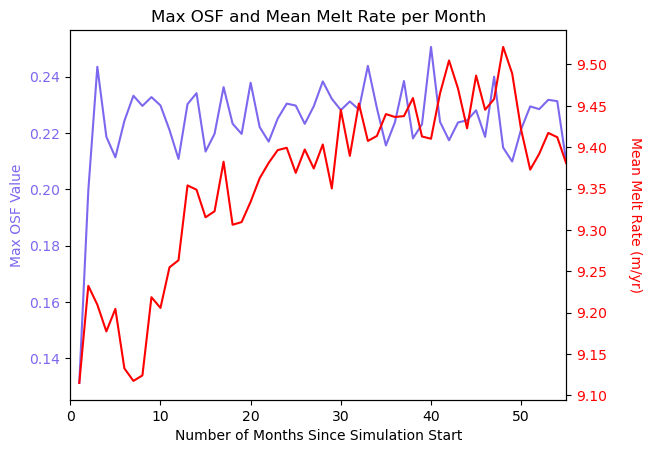

In [23]:
## calculate max osf per month
ds_inCavity = ds.isel(nx=slice(0,furthest_x_idx+1))
max_osf = ds_inCavity.osf.max(dim=["nx", "nz"])

## calculate the mean melt rate per month; adapted from compass source code
ds_output = xr.open_dataset('/pscratch/sd/m/mlarson/isomip_plus_2km_z-star_Ocean0/ocean/isomip_plus/planar/2km/z-star/Ocean0/simulation/land_ice_fluxes.nc')
ds_timeMonthly = xr.open_mfdataset('/pscratch/sd/m/mlarson/isomip_plus_2km_z-star_Ocean0/ocean/isomip_plus/planar/2km/z-star/Ocean0/simulation/timeSeriesStatsMonthly.*.nc')
rho_fw = 1000.
secPerYear = 365 * 24 * 60 * 60
areaCell = ds_output.areaCell
iceMask = ds_timeMonthly.timeMonthly_avg_landIceFraction
meltFlux = ds_timeMonthly.timeMonthly_avg_landIceFreshwaterFlux
totalMeltFlux = (meltFlux * areaCell * iceMask).sum(dim='nCells')
totalArea = (areaCell * iceMask).sum(dim='nCells')
meanMeltRate = totalMeltFlux / totalArea / rho_fw * secPerYear

## plot figure
fig, ax1 = plt.subplots()

##first plot the max OSF per month
ax1.plot(np.arange(1,len(ds_inCavity.Time)+1), max_osf, color='mediumslateblue')
ax1.set_ylabel('Max OSF Value', color='mediumslateblue')
ax1.tick_params(axis='y', labelcolor='mediumslateblue')

ax2 = ax1.twinx()
ax2.plot(np.arange(1,len(ds_output.Time)+1),meanMeltRate,color='red')
ax2.set_ylabel('Mean Melt Rate (m/yr)', color='red', rotation=-90, labelpad=25)
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Max OSF and Mean Melt Rate per Month')
ax1.set_xlabel('Number of Months Since Simulation Start')

ax1.set_xlim(0,55)
plt.show()